In [10]:
############################
#Author
#Lingjing Wang and Xiang Li
#Date: June 2020
############################

%matplotlib inline
import glob
import numpy as np
import os
import pandas as pd
from scipy.io import loadmat
import matplotlib.pylab as plt
import glob
from scipy.ndimage.interpolation import rotate
import scipy
import tensorflow as tf
import Utils
import h5py
from mpl_toolkits.mplot3d import Axes3D
colorsMap='jet'
import matplotlib
import matplotlib.cm as cmx

In [11]:
# DD input point sets; LL categorical label; PP point label
data_path = '/home/donglin/Github/acronym-partnet/data/'
DD = np.load(data_path + 'combined_points.npy')
LL = np.load(data_path + 'combined_shape_labels.npy')
PP = np.load(data_path + 'combined_point_labels.npy')
print(DD.shape, LL.shape, PP.shape)

(11823, 2048, 3) (11823,) (11823, 2048)


In [16]:
cls=7 # Mug BABY!!!!!
num_temp=4 # choose number of templates


ind=(LL==cls).reshape(-1,)
dd=DD[ind][:,:,:]
pp=PP[ind]

# Choose templates with point label information
# tmp=np.random.choice(range(len(dd)),num_temp)
tmp = [0,1,2]
#chair
# tmp=[0,2,5,8,9,16,39,51,285,305]

# dT: template point sets; pT: template points' segmentation labels; dd: target point sets; pp: target points' segmentation labels
dT=dd[tmp]
pT=pp[tmp]
dd=dd[np.asarray([i for i in range(len(dd)) if i not in tmp])]
pp=pp[np.asarray([i for i in range(len(pp)) if i not in tmp])]
print(dT.shape, pT.shape, dd.shape, pp.shape)

(4, 2048, 3) (4, 2048) (243, 2048, 3) (243, 2048)


In [17]:
def chamfer_loss_np(A,B):    
    r=np.sum(A*A,2)
    r=np.reshape(r,[int(r.shape[0]),int(r.shape[1]),1])
    r2=np.sum(B*B,2)
    r2=np.reshape(r2,[int(r.shape[0]),int(r.shape[1]),1])
    t=(r-2*np.matmul(A, np.transpose(B,(0, 2, 1)))+ np.transpose(r2,(0, 2, 1)))
    return np.mean((np.min(t, axis=1)+np.min(t,axis=2))/2.0,axis=-1)

In [18]:
# For each shape as target point sets, we firstly retrive the nearest template with labels for them.
# This process might take a while if you have a large number of target shapes 
D=[] 
P=[]
T=[]
TP=[]

for j in range(len(dd)):
#     print(j)
    xx=dd[j]
    xx=np.tile(np.expand_dims(xx,0),[num_temp,1,1])
    cl=chamfer_loss_np(xx[:,:,:], dT[:,:,:])
    n=np.argmin(np.asarray(cl).reshape(-1))
    
    D.append(dd[j])
    P.append(pp[j])
    T.append(dT[n])
    TP.append(pT[n])
    
    if j%10 == 0:
        print(j)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


In [19]:
print(np.array(D).shape, np.array(P).shape, np.array(T).shape, np.array(TP).shape)

(243, 2048, 3) (243, 2048) (243, 2048, 3) (243, 2048)


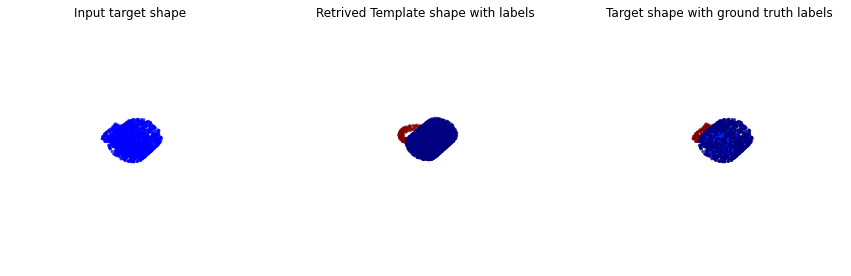

In [20]:
# visulize the dataset:
x=D[0]
cs=P[0]
fig = plt.figure(1, figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1, projection='3d')
x=Utils.rotate_90_degree(Utils.rotate_90_degree(Utils.rotate_90_degree(x)))
cm = plt.get_cmap(colorsMap)
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
# ax.scatter(x[:,1], x[:,2], x[:,0], c=scalarMap.to_rgba(cs),s=4)
ax.scatter(x[:,1], x[:,2], x[:,0], c='b',s=4)
scalarMap.set_array(cs)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.title('Input target shape')
plt.axis("off")
ax = fig.add_subplot(1, 3, 2, projection='3d')
x=T[0]
cs=TP[0]
x=Utils.rotate_90_degree(Utils.rotate_90_degree(Utils.rotate_90_degree(x)))
cm = plt.get_cmap(colorsMap)
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
ax.scatter(x[:,1], x[:,2], x[:,0], c=scalarMap.to_rgba(cs),s=4)
scalarMap.set_array(cs)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.axis("off")
plt.title('Retrived Template shape with labels')
ax = fig.add_subplot(1, 3, 3, projection='3d')
x=D[0]
cs=P[0]
fig = plt.figure(1, figsize=(15, 5))
x=Utils.rotate_90_degree(Utils.rotate_90_degree(Utils.rotate_90_degree(x)))
cm = plt.get_cmap(colorsMap)
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
ax.scatter(x[:,1], x[:,2], x[:,0], c=scalarMap.to_rgba(cs),s=4)
scalarMap.set_array(cs)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.title('Target shape with ground truth labels ')
plt.axis("off")
plt.show()

In [21]:
np.asarray(P).min()

8

In [22]:
Utils.write_to_tfrecords({"D":np.asarray(D),"P":np.asarray(P)-np.asarray(P).min(),"T":np.asarray(T),"TP":np.asarray(TP)-np.asarray(P).min()},
                           "./mug_N2048.tfrecords")

writing successfully in your dir:./mug_N2048.tfrecords


In [26]:
print(np.unique(np.asarray(TP)-np.asarray(P).min()))
print(np.unique(np.asarray(P)-np.asarray(P).min()))

[0 6]
[0 1 6]
